In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['figure.dpi'] = 190

In [3]:
def get_iris_dataset(normalized=None):
    """
    Funcion auxiliar para el notebook
    normalized: puede tener None, 'zero mean and unit variance', 'zero mean' como valores validos
    """
    X, y = load_iris(return_X_y=True)

    if normalized == 'zero mean and unit variance':
        min_max_scaler = preprocessing.MinMaxScaler()
        X = min_max_scaler.fit_transform(
            X
        )  # preunta alumnos: que estoy haciendo mal aca? (pss leaking)

    if normalized == 'zero mean':
        normalizer = preprocessing.Normalizer()
        X = normalizer.fit_transform(
            X
        )  # preunta alumnos: que estoy haciendo mal aca? (pss leaking)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.5, random_state=0
    )
    return X_train, X_test, y_train, y_test

In [4]:
dataset = load_iris()
df = pd.DataFrame(dataset.data, columns=dataset.feature_names)
df['target_id'] = dataset.target
df['target_name'] = df.target_id.apply(lambda x: dataset.target_names[x])
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target_id,target_name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


# KNN
https://scikit-learn.org/stable/modules/neighbors.html

Ejemplo simple

In [5]:
from sklearn.neighbors import KNeighborsClassifier

X_train, X_val_dev, y_train, y_val_dev = get_iris_dataset()
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_val_dev)
y_pred

array([2, 1, 0, 2, 0, 2, 0, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 0, 0, 2, 1,
       0, 0, 2, 0, 0, 1, 1, 0, 2, 1, 0, 2, 2, 1, 0, 2, 1, 1, 2, 0, 2, 0,
       0, 1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 1, 0, 2, 1, 1, 1,
       1, 2, 0, 0, 2, 1, 0, 0, 1])

In [6]:
print('correctas: ', np.sum(y_val_dev == y_pred))
print('total: ', len(y_val_dev))

correctas:  72
total:  75


mejor puntaje:  73 correctos


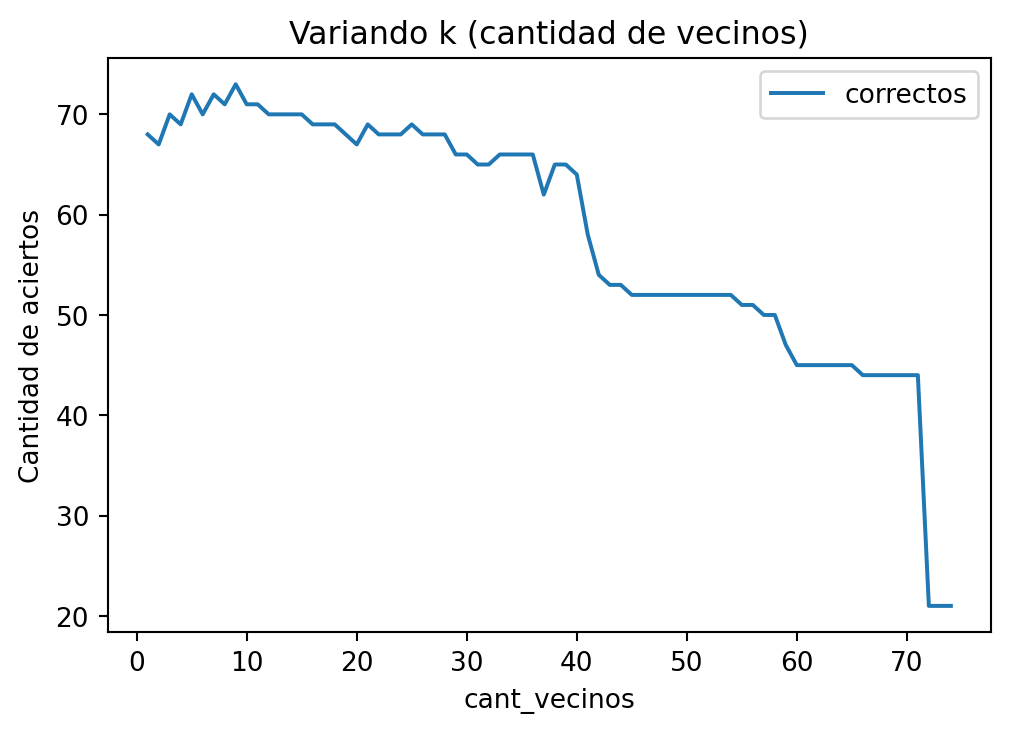

In [7]:
# cargamos dataset
X_train, X_val_dev, y_train, y_val_dev = get_iris_dataset()

# calculamos variando K
metrics = []
for n in range(1, len(X_val_dev)):
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_val_dev)
    metrics.append((n, (y_val_dev == y_pred).sum()))

# ploteamos
df_metrics = pd.DataFrame(metrics, columns=['cant_vecinos', 'correctos'])
print('mejor puntaje: ', max(df_metrics.correctos), 'correctos')
ax = df_metrics.plot(
    x='cant_vecinos', y='correctos', title='Variando k (cantidad de vecinos)'
)
ax.set_ylabel("Cantidad de aciertos")
plt.show()

### Que pasa si se elige a n vecinos igual al total de puntos?

In [8]:
pd.Series(y_train).value_counts()

0    29
2    26
1    20
dtype: int64

In [9]:
pd.Series(y_pred).value_counts()

0    75
dtype: int64

In [10]:
pd.Series(y_val_dev).value_counts()

1    30
2    24
0    21
dtype: int64

In [11]:
21 / (30 + 24 + 21)

0.28

### Todos los atributos de cada ejemplo pesan lo mismo ??

In [12]:
X_train, X_test, y_train, y_test = get_iris_dataset(
    normalized='zero mean and unit variance'
)

metrics = []
for n in range(1, len(X_test)):
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    metrics.append((n, (y_test == y_pred).sum()))

df_metrics_normalized_unit_variance = pd.DataFrame(
    metrics, columns=['cant_vecinos', 'correctos']
)

In [13]:
X_train, X_test, y_train, y_test = get_iris_dataset(normalized='zero mean')

metrics = []
for n in range(1, len(X_test)):
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    metrics.append((n, (y_test == y_pred).sum()))

df_metrics_normalized = pd.DataFrame(metrics, columns=['cant_vecinos', 'correctos'])

Text(0, 0.5, 'Cantidad de aciertos')

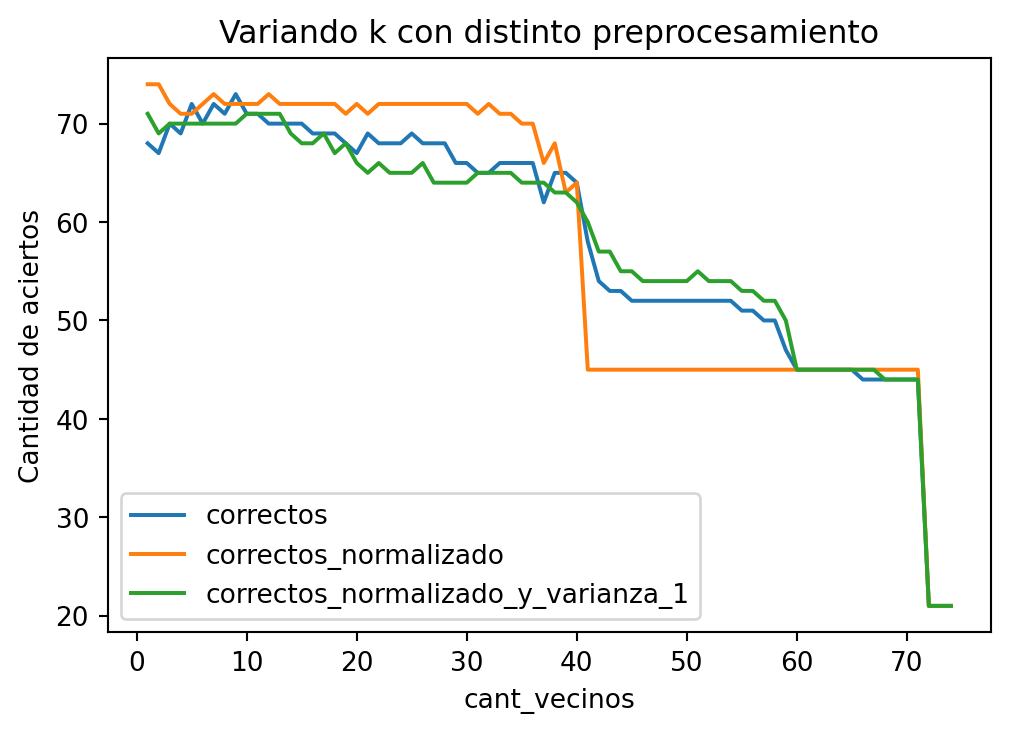

In [14]:
df = df_metrics.merge(
    df_metrics_normalized,
    on='cant_vecinos',
    validate="1:1",
    suffixes=('', '_normalizado'),
)
df = df.merge(
    df_metrics_normalized_unit_variance,
    on='cant_vecinos',
    suffixes=('', '_normalizado_y_varianza_1'),
    validate="1:1",
)
ax = df.plot(x='cant_vecinos', title='Variando k con distinto preprocesamiento')
ax.set_ylabel("Cantidad de aciertos")

### Que pasa con la distancia entre los puntos, todos los vecinos valen lo mismo?

,cant_vecinos,tipo de peso,correctos
3,6,distance,73
4,7,uniform,73


3    Line2D(_line4)
4    Line2D(_line5)
dtype: object

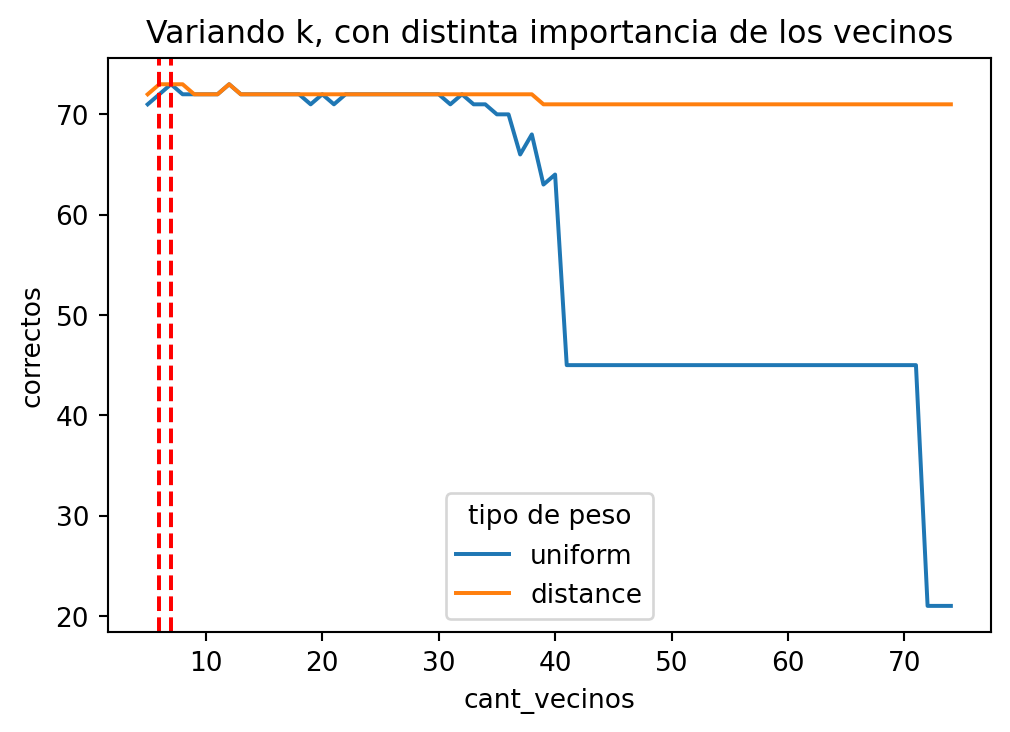

In [15]:
# probar que pasa si cambio el parametro weights
# weights:
# - 'uniform' : uniform weights.  All points in each neighborhood are weighted equally.
# - 'distance' : weight points by the inverse of their distance.

metrics = []
for n in range(5, len(X_test)):
    for distance_type in ['uniform', 'distance']:
        knn = KNeighborsClassifier(n_neighbors=n, weights=distance_type)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        metrics.append((n, distance_type, (y_test == y_pred).sum()))

# ploteo grafico
df_metrics_normalized = pd.DataFrame(
    metrics, columns=['cant_vecinos', 'tipo de peso', 'correctos']
)
ax = sns.lineplot(
    data=df_metrics_normalized, x='cant_vecinos', y='correctos', hue='tipo de peso'
)
ax.set_title('Variando k, con distinta importancia de los vecinos')

# ploteo lines rojas y muestro mejores lugares
g = df_metrics_normalized.groupby('tipo de peso')
df_max = df_metrics_normalized.iloc[g['correctos'].idxmax()]
display(df_max)
df_max.apply(lambda x: ax.axvline(x.cant_vecinos, color='red', linestyle='--'), axis=1)

### Como se calcula la distancia?


In [16]:
# Explicar por arriba que hay distintas funciones de distancia
# mostrar en sklearn como usarlas
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances.html

from sklearn.metrics.pairwise import PAIRWISE_DISTANCE_FUNCTIONS
from sklearn.neighbors import BallTree
from sklearn.neighbors import KDTree

# codigo sacado de from sklearn.neighbors.classification import NeighborsBase
# https://atavory.github.io/ibex/_modules/sklearn/neighbors/base.html
VALID_METRICS = dict(
    ball_tree=BallTree.valid_metrics,
    kd_tree=KDTree.valid_metrics,
    # The following list comes from the sklearn.metrics.pairwise doc string
    brute=list(PAIRWISE_DISTANCE_FUNCTIONS.keys())
    + [
        'braycurtis',
        'canberra',
        'chebyshev',
        'correlation',
        'cosine',
        'dice',
        'hamming',
        'jaccard',
        'kulsinski',
        'mahalanobis',
        'matching',
        'minkowski',
        'rogerstanimoto',
        'russellrao',
        'seuclidean',
        'sokalmichener',
        'sokalsneath',
        'sqeuclidean',
        'yule',
        'wminkowski',
    ],
)

for alg in VALID_METRICS:
    print(f'algoritmo: {alg}')
    print(VALID_METRICS[alg])
    print()

algoritmo: ball_tree
['euclidean', 'l2', 'minkowski', 'p', 'manhattan', 'cityblock', 'l1', 'chebyshev', 'infinity', 'seuclidean', 'mahalanobis', 'wminkowski', 'hamming', 'canberra', 'braycurtis', 'matching', 'jaccard', 'dice', 'kulsinski', 'rogerstanimoto', 'russellrao', 'sokalmichener', 'sokalsneath', 'haversine', 'pyfunc']

algoritmo: kd_tree
['euclidean', 'l2', 'minkowski', 'p', 'manhattan', 'cityblock', 'l1', 'chebyshev', 'infinity']

algoritmo: brute
['cityblock', 'cosine', 'euclidean', 'haversine', 'l2', 'l1', 'manhattan', 'precomputed', 'nan_euclidean', 'braycurtis', 'canberra', 'chebyshev', 'correlation', 'cosine', 'dice', 'hamming', 'jaccard', 'kulsinski', 'mahalanobis', 'matching', 'minkowski', 'rogerstanimoto', 'russellrao', 'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean', 'yule', 'wminkowski']



# Explicar KD-Tree en pizarra

,cant_vecinos,tipo de peso,correctos
1,1,distance,74
0,1,uniform,74


1    Line2D(_line4)
0    Line2D(_line5)
dtype: object

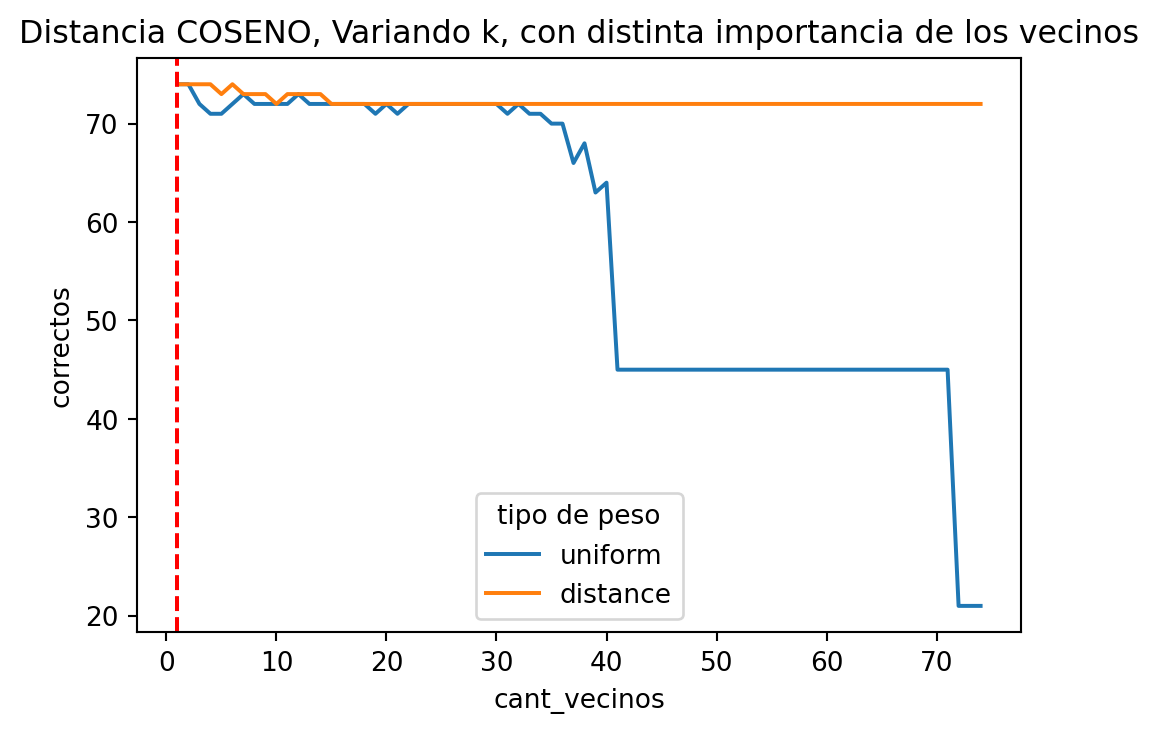

In [17]:
metrics = []
for n in range(1, len(X_test)):
    for distance_type in ['uniform', 'distance']:
        knn = KNeighborsClassifier(
            n_neighbors=n, weights=distance_type, metric='cosine'
        )
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        metrics.append((n, distance_type, (y_test == y_pred).sum()))

# ploteo grafico
df_metrics_normalized = pd.DataFrame(
    metrics, columns=['cant_vecinos', 'tipo de peso', 'correctos']
)
ax = sns.lineplot(
    data=df_metrics_normalized, x='cant_vecinos', y='correctos', hue='tipo de peso'
)
ax.set_title('Distancia COSENO, Variando k, con distinta importancia de los vecinos')

# ploteo lines rojas y muestro mejores lugares
g = df_metrics_normalized.groupby('tipo de peso')
df_max = df_metrics_normalized.iloc[g['correctos'].idxmax()]
display(df_max)
df_max.apply(lambda x: ax.axvline(x.cant_vecinos, color='red', linestyle='--'), axis=1)

### Como es el orden computacional de esto?


explicar MUY por arriba que es el parametro algorithm
algorithm : {'auto', 'ball_tree', 'kd_tree', 'brute'}

In [18]:
# https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/lecturenote16.html
# parte 1: https://youtu.be/BzHJ57QCdVo?t=1754
# parte 2: https://youtu.be/E1_WCdUAtyE

# KNeighborsClassifier(algorithm='auto')
# KNeighborsClassifier(algorithm='ball_tree')
# KNeighborsClassifier(algorithm='kd_tree')
# KNeighborsClassifier(algorithm='brute')


> otra variacion
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.RadiusNeighborsClassifier.html

> Tambien se puede mezclar las dos haciendo que RadiusNeighborsClassifier devuelva todos los vecinos
y quedarme con los k más cercanos.

In [19]:
# TODO: Ver si tiene sentido (Reduccion de dimensionalidad + KNN)

# Ver si tiene sentido:
# siguiendo esta linea: https://scikit-learn.org/stable/auto_examples/neighbors/plot_nca_dim_reduction.html
# Ver si consigo un dataset con muchas dimensiones (o crear uno)
# Aplicar KNN
# Ver la performance
# Reducir dimensionalidad con PCA
# Aplicar KNN
# Ver la performance

### Che jorge, que pasa si tengo millones de puntos y KNN de sklearn se queda corto?
- https://github.com/spotify/annoy
- https://github.com/facebookresearch/faiss

# Naive Bayes

https://scikit-learn.org/stable/modules/naive_bayes.html

Regla memotecnica:
- Cuando trabajamos con features continuos -> (GaussianNB)
- Cuando trabajamos con features discretos -> (MultinomialNB)
- Cuando trabajamos con features categoricos -> (CategoricalNB) (No es muy importante)

### Aplicando Gaussian Naive Bayes

Porque gaussian NB para este dataset?

In [20]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print(f"Number of correct {(y_test == y_pred).sum()} of total {len(X_test)}")

Number of correct 71 of total 75


### Aplicando Multinomial Naive Bayes

In [21]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
gnb = MultinomialNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print(f"Number of correct {(y_test == y_pred).sum()} of total {len(X_test)}")

# pregunta al alumno: porque anda tan mal ?

Number of correct 45 of total 75


### Mezcalando valores continuos, discretos y categoricos

Nota: Ya que sklearn no tiene la funcionalidad de trabajar al mismo tiempo con variables categoricas y variables continuas (una limitante bastante pava que se deberia solucionar). Se podria hacer un ensamble agarramos las probabilidades de GaussianNB, MultinomialNB y CategoricalNB y le metemos un gaussianNB al final juntando lo que devuelven los anteriores.

# Support Vector Machines (SVM)

 - https://scikit-learn.org/stable/modules/svm.html

Links de Interes:
- https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html#sphx-glr-auto-examples-svm-plot-separating-hyperplane-py

- https://scikit-learn.org/stable/auto_examples/svm/plot_svm_kernels.html#sphx-glr-auto-examples-svm-plot-svm-kernels-py

- https://scikit-learn.org/stable/auto_examples/exercises/plot_iris_exercise.html#sphx-glr-auto-examples-exercises-plot-iris-exercise-py


In [22]:
# Vemos que SVM tambien es sensible a la escala y distribucion de los datos
from sklearn.svm import SVC

for normalization_mode in [None, 'zero mean and unit variance', 'zero mean']:
    X_train, X_val_dev, y_train, y_val_dev = get_iris_dataset(normalization_mode)
    clf = SVC()
    clf.fit(X_train, y_train)
    print(
        'preprocesamiento: ',
        normalization_mode,
        'Correctos: ',
        (clf.predict(X_val_dev) == y_val_dev).sum(),
    )

preprocesamiento:  None Correctos:  71
preprocesamiento:  zero mean and unit variance Correctos:  72
preprocesamiento:  zero mean Correctos:  69


# Vamos a probar distintos kernels:

Lista: https://scikit-learn.org/dev/modules/svm.html#svm-kernels

## SVM con kernel LINEAL
Hyperparametros que le importan:
- C


Nota: tambien esta https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
que es una implementacion de lineal implementada de forma "mas eficiente"

<AxesSubplot:xlabel='c'>

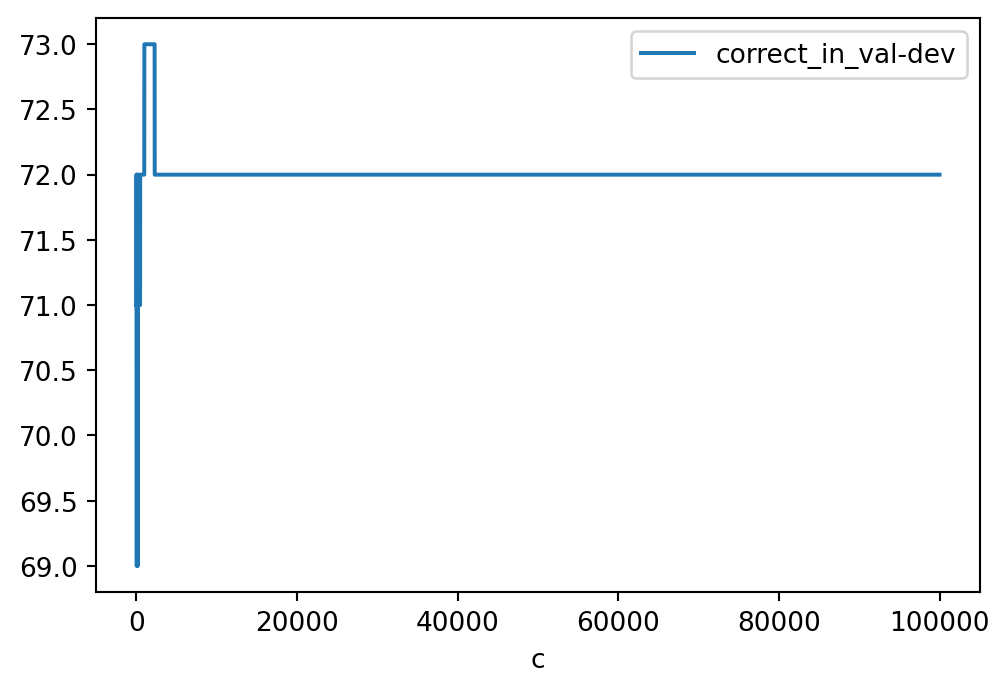

In [23]:
metrics = []
X_train, X_val_dev, y_train, y_val_dev = get_iris_dataset('zero mean and unit variance')

for c in range(1, 100000, 2):
    clf = SVC(kernel='linear', C=c)
    clf.fit(X_train, y_train)
    metrics.append((c, (clf.predict(X_val_dev) == y_val_dev).sum()))

pd.DataFrame(metrics, columns=['c', 'correct_in_val-dev']).plot(x='c')

## SVM con kernel POLINOMICO

Hyperparametros que le interesan:
- C
- degree
- gamma
- coef0(que es r en nuestras cuentas de la teorica)


In [24]:
X_train, X_val_dev, y_train, y_val_dev = get_iris_dataset('zero mean and unit variance')

metrics = []
for c in range(1, 100, 10):
    for d in range(1, 100, 10):
        for g in range(1, 100, 10):
            for r in range(1, 100, 10):
                clf = SVC(kernel='poly', C=c, degree=d, gamma=g, coef0=r)
                clf.fit(X_train, y_train)
                metrics.append(
                    (c, d, g, r, (clf.predict(X_val_dev) == y_val_dev).sum())
                )

dd = pd.DataFrame(metrics, columns=['c', 'degree', 'gamma', 'r', 'correct_in_val-dev'])

In [25]:
dd[dd['correct_in_val-dev'] == dd['correct_in_val-dev'].max()]

,c,degree,gamma,r,correct_in_val-dev
101,1,11,1,11,73
102,1,11,1,21,73
103,1,11,1,31,73
114,1,11,11,41,73
115,1,11,11,51,73
...,...,...,...,...,...
9129,91,11,21,91,73
9203,91,21,1,31,73
9204,91,21,1,41,73
9205,91,21,1,51,73


## Tratemos de visualizar en 3d dos hiperparametros

In [26]:
%matplotlib widget

In [27]:
metrics = []
X_train, X_val_dev, y_train, y_val_dev = get_iris_dataset('zero mean and unit variance')
for d in (1, 10):
    for c in range(1, 10000, 10):
        clf = SVC(kernel='poly', C=c, degree=d)
        clf.fit(X_train, y_train)
        metrics.append((c, d, (clf.predict(X_val_dev) == y_val_dev).sum()))

dd = pd.DataFrame(metrics, columns=['c', 'd', 'correct_in_val-dev'])

# Make the plot
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(dd.c, dd.d, dd['correct_in_val-dev'], cmap=plt.cm.viridis)
ax.set_xlabel('c')
ax.set_ylabel('d')
ax.set_zlabel('correct')
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [28]:
# ! pip install ipympl

## SVM RADIAL

Hyperparametros que le interesan:
 - C
 - gamma


In [29]:
X_train, X_val_dev, y_train, y_val_dev = get_iris_dataset('zero mean and unit variance')

metrics = []
for c in range(1, 100, 10):
    for g in range(1, 100, 10):
        clf = SVC(kernel='rbf', C=c, gamma=g)
        clf.fit(X_train, y_train)
        metrics.append((c, g, (clf.predict(X_val_dev) == y_val_dev).sum()))

dd = pd.DataFrame(metrics, columns=['c', 'gamma', 'correct_in_val-dev'])


In [30]:
dd[dd['correct_in_val-dev'] == dd['correct_in_val-dev'].max()]

,c,gamma,correct_in_val-dev
1,1,11,72
40,41,1,72
90,91,1,72
